In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

import requests
data = requests.get('http://www.gutenberg.org/files/1399/1399-h/1399-h.htm')
content = data.content

Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models, popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-Grams, and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence, and context around nearby words in each text document. This forms as enough motivation for us to explore more sophisticated models that can capture this information and give us features that are vector representation of words, popularly known as embeddings .

To overcome the shortcomings of the Bag of Words model, we need to use vector space models (VSMs) in such a way that we can embed word vectors in this continuous vector space based on semantic and contextual similarity.

In [3]:
import re
from bs4 import BeautifulSoup
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

from contractions import CONTRACTION_MAP
import re
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

import spacy
nlp = spacy.load('en', parse=True, tag=True, entity=True)
text = 'My system keeps crashing his crashed yesterday, ours crashes daily'
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    # this will remove the white spaces from the tokens
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

default_st = nltk.sent_tokenize

def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True,
                     text_lemmatization=True, special_char_removal=True,
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    
    # tokenize each sentence in corpus
    corpus = default_st(text=corpus)
    
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        normalized_corpus.append(doc)
    return normalized_corpus

In [54]:
clean_content = strip_html_tags(content)
sample_text = clean_content[1932:-1]

sentences = default_st(text=sample_text)
norm_sentences = normalize_corpus(sample_text)

In [55]:
print('Total lines:', len(norm_sentences))
print('\nSample line:', sentences[6])
print('\nProcessed line:', norm_sentences[6])

Total lines: 16923

Sample line: The children ran wild all over the house;
the English governess quarreled with the housekeeper, and wrote to a friend
asking her to look out for a new situation for her; the man-cook had walked off
the day before just at dinner time; the kitchen-maid, and the coachman had
given warning.

Processed line: child run wild house english governess quarrel housekeeper write friend ask look new situation man cook walk day dinner time kitchen maid coachman give warning


### WORD2VEC MODEL

This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed, and continuous dense vector representations of words that capture contextual and semantic similarity.

The Gensim framework , created by Radim Řehůřek, consists of a robust, efficient, and scalable implementation of the Word2Vec model. We will leverage this on 'Anna Karenina'. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it. The basic idea is to provide a corpus of documents as input and get feature vectors for the output.

In [61]:
from gensim.models import word2vec
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()

tokenized_corpus = [wpt.tokenize(document) for document in norm_sentences]

# Set values for various parameters
feature_size = 150    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)


# view similar words based on gensim's model
similar_words = {search_term: [item[0]
                     for item in w2v_model.wv.most_similar([search_term], topn=5)]
                         for search_term in ['anna', 'governess', 'children', 'warning', 'happiness']}
similar_words

{'anna': ['annas', 'trepidation', 'dolly', 'governess', 'terrace'],
 'governess': ['grisha', 'english', 'disobedient', 'lesson', 'tart'],
 'children': ['latinit', 'propensity', 'mashas', 'mothersand', 'roost'],
 'warning': ['situation', 'kitchen', 'traveling', 'busy', 'empire'],
 'happiness': ['bliss', 'purity', 'sweetness', 'creature', 'passion']}

Let’s also visualize the words of interest and their similar words using their embedding vectors after reducing their dimensions to a 2D space with t-SNE.

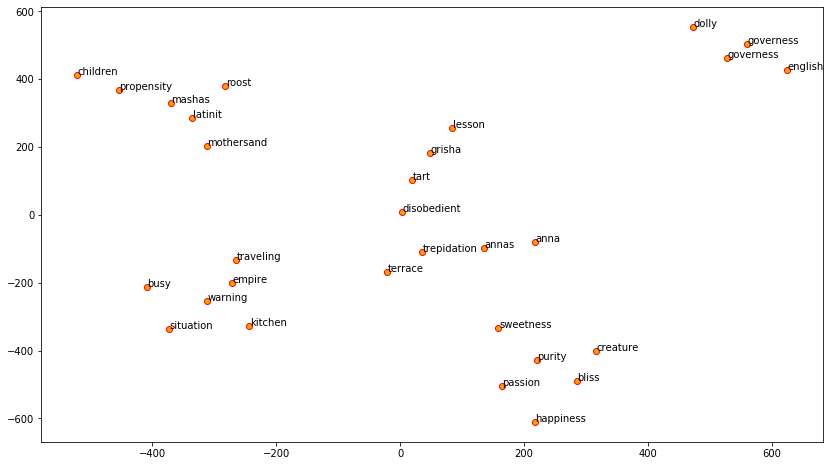

In [62]:
similar_words = {search_term: [item[0]
                     for item in w2v_model.wv.most_similar([search_term], topn=5)]
                         for search_term in ['anna', 'governess', 'children', 'warning', 'happiness']}

from sklearn.manifold import TSNE
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c="orange", edgecolors="r")
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

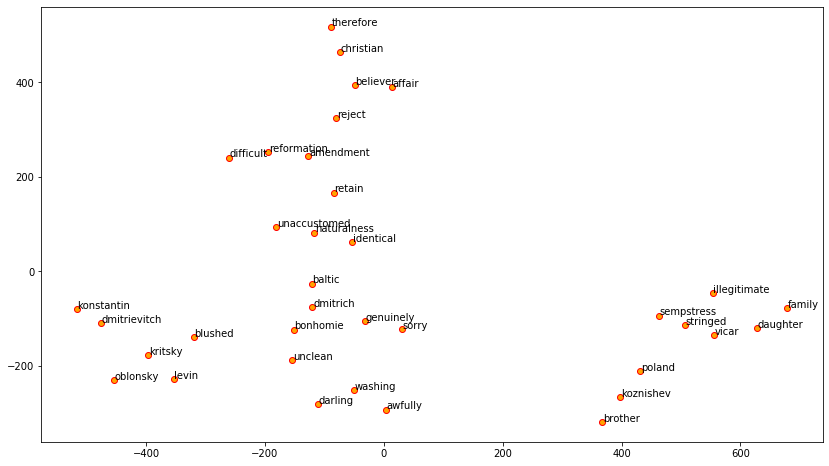

In [63]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0]
                     for item in w2v_model.wv.most_similar([search_term], topn=5)]
                         for search_term in ['oblonsky', 'levin', 'sorry', 'family', 'affair', 'difficult']}

from sklearn.manifold import TSNE
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c="orange", edgecolors="r")
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### try for part of the book

In [34]:
# let's select fewer sentences for embedding

clean_content = strip_html_tags(content)
sample_text = clean_content[1932:8000]

sentences = default_st(text=sample_text)
norm_sentences = normalize_corpus(sample_text)

In [35]:
print('Total lines:', len(norm_sentences))
print('\nSample line:', sentences[6])
print('\nProcessed line:', norm_sentences[6])

Total lines: 47

Sample line: The children ran wild all over the house;
the English governess quarreled with the housekeeper, and wrote to a friend
asking her to look out for a new situation for her; the man-cook had walked off
the day before just at dinner time; the kitchen-maid, and the coachman had
given warning.

Processed line: child run wild house english governess quarrel housekeeper write friend ask look new situation man cook walk day dinner time kitchen maid coachman give warning


In [36]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_sentences]
# Set values for various parameters
feature_size = 10    # Word vector dimensionality
window_context = 10          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count = min_word_count, sample=sample, iter=100)

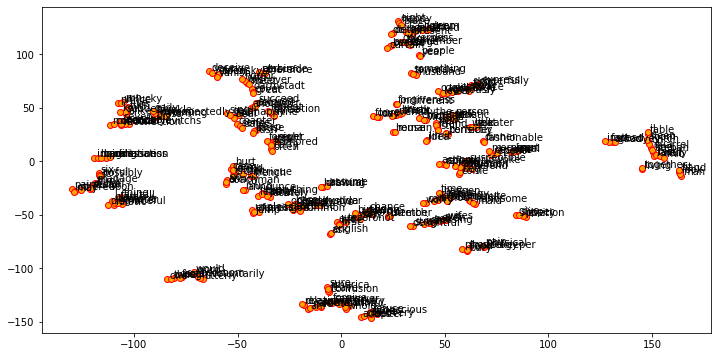

In [37]:
# visualize embeddings of all text
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c="orange", edgecolors="r")
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [38]:
wvs.shape, len(words)

((312, 10), 312)

In [41]:
w2v_model.wv['table']

array([-0.9602971 ,  0.08855737, -0.8041159 ,  0.7928198 , -0.3409637 ,
       -0.74885535,  1.2618951 , -1.2827642 ,  0.28376266, -0.8567206 ],
      dtype=float32)

### getting embedded dataframe

In [39]:
df = pd.DataFrame(wvs)
df.index = words
df.T

,wife,stepan,yes,smile,family,husband,day,arkadyevitch,part,one,...,two,dead,young,better,hide,difficulty,sorry,possibly,may,manage
0,-1.118619,-0.941246,-0.502433,-0.743517,-0.987166,-0.787015,-0.776536,-0.851490,-0.799936,-1.307222,...,-0.667777,-0.614040,-0.475593,-0.330714,-0.311084,-0.272816,-0.266691,-0.341985,-0.281728,-0.368712
1,0.015594,0.069995,0.046676,0.024649,0.065737,0.067090,0.024701,-0.004820,0.097508,-0.002938,...,0.035038,0.037631,0.057315,0.077602,0.042847,-0.020356,-0.041915,-0.036807,-0.009564,-0.016879
2,-0.967502,-0.885507,-0.443881,-0.645050,-0.901098,-0.753294,-0.676703,-0.870307,-0.732184,-1.172326,...,-0.585976,-0.495753,-0.414154,-0.184391,-0.231295,-0.206253,-0.172577,-0.215963,-0.344846,-0.299456
3,0.934472,0.793177,0.369555,0.579903,0.801369,0.642671,0.566159,0.703481,0.691681,1.132696,...,0.540008,0.456808,0.379909,0.190115,0.216399,0.221965,0.180203,0.271011,0.310279,0.287333
4,-0.344057,-0.327045,-0.139544,-0.225751,-0.274438,-0.267631,-0.283713,-0.289587,-0.205726,-0.380160,...,-0.229194,-0.187191,-0.121579,-0.046644,-0.131461,-0.042651,-0.115460,-0.067648,-0.039159,-0.091741
5,-1.040561,-0.860417,-0.426904,-0.669760,-0.887749,-0.693447,-0.655251,-0.788921,-0.728150,-1.309330,...,-0.622207,-0.570622,-0.388449,-0.201427,-0.243443,-0.252910,-0.230030,-0.242547,-0.250147,-0.286077
6,1.594536,1.311456,0.699717,0.988273,1.392479,1.042821,1.043210,1.286270,1.080791,1.783224,...,0.950848,0.776611,0.619169,0.342100,0.314126,0.303906,0.305363,0.447008,0.396022,0.448805
7,-1.726909,-1.542304,-0.726049,-1.110462,-1.369832,-1.165582,-1.114818,-1.433454,-1.076555,-1.835510,...,-0.969592,-0.923230,-0.639939,-0.466549,-0.435707,-0.380635,-0.382990,-0.484279,-0.502182,-0.413647
8,0.409295,0.375140,0.177439,0.254640,0.375376,0.268355,0.305677,0.327963,0.320130,0.493090,...,0.316354,0.241721,0.233804,0.136032,0.064345,0.067055,0.117834,0.119023,0.149124,0.153746
9,-1.016965,-0.885245,-0.489031,-0.691694,-0.841067,-0.729297,-0.669888,-0.814591,-0.610878,-1.144485,...,-0.561179,-0.487262,-0.361297,-0.217825,-0.211476,-0.202935,-0.228792,-0.252082,-0.353193,-0.321998


### GloVe model 

The GloVe (Global Vectors) model is a unsupervised learning model that can be used to obtain dense word vectors similar to Word2Vec. However, the technique is different and training is performed on an aggregated global word-word co-occurrence matrix, giving us a vector space with meaningful sub-structures. 

In [65]:
import spacy
nlp = spacy.load('en')
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 0
